In [2]:
import pandas as pd
from COMETH import Skeleton,DynamicSkeleton
import nimblephysics as nimble
import numpy as np
import time
import matplotlib.pyplot as plt
import os
gui = nimble.NimbleGUI()
gui.serve(8080)

# sudo lsof -iTCP:8080 -sTCP:LISTEN

GUIWebsocketServer will start serving a WebSocket server on ws://localhost:8070
Web GUI serving on http://localhost:8080


### Skeleton instance and loading a scene from Totalcapture dataset

In [3]:
gui.nativeAPI().clear()
# Build skeleton
s12 = Skeleton('BODY12.xml')
# BSM
s = DynamicSkeleton(config='BODY15_constrained_3D.xml',osim_file=os.path.abspath('COMETH/bsm_upper.osim'))
s.hip_correction = False

# plot xyz axis
axis_length=0.2
gui.nativeAPI().createLine(key='x_axis',points=[np.array([0,0,0]),np.array([axis_length,0,0])],color=np.array([255,0,0,1]))
gui.nativeAPI().createLine(key='y_axis',points=[np.array([0,0,0]),np.array([0,axis_length,0])],color=np.array([0,255,0,1]))
gui.nativeAPI().createLine(key='z_axis',points=[np.array([0,0,0]),np.array([0,0,axis_length])],color=np.array([0,0,255,1]))

# Read data from CSV
markers = pd.read_csv("tmp/imu/vicon_s1_acting1.csv")
imus = pd.read_csv("tmp/imu/imu_s1_acting1.csv")

# Build the markers dataframe with only the subset we are interested in
Rz = np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

Rx = np.array([
    [1,0,0 ],
    [0,0,-1 ],
    [0,1,0]
])

markers.columns
markers_dict = {
'RKnee': 'right_knee',
'LWrist': 'left_wrist',
'RHip': 'right_hip',
'RShoulder': 'right_shoulder',
'LElbow': 'left_elbow',
'LHip': 'left_hip',
'RElbow': 'right_elbow',
'RWrist': 'right_wrist',
'LKnee': 'left_knee',
'LShoulder': 'left_shoulder',
'RAnkle': 'right_ankle',
'LAnkle': 'left_ankle'
 }
target = []
for i in range(markers.shape[0]):
    row = []
    for kp in markers_dict.keys():
        p = np.array([markers[markers_dict[kp]+"_x"][i],markers[markers_dict[kp]+"_y"][i],markers[markers_dict[kp]+"_z"][i]])
        # rotate the 3d point -90 on the x axis (from y up to z up)
        p_n = Rz.dot(Rx.dot(p))
        # print(p,p_n)
        row += p_n.tolist()
    target.append(row)
target = np.array(target)

# Move the body model using gt to the first position
kps = list(markers_dict.keys())
s.reset()
s12.load_from_numpy(target[0,:].reshape(-1,3),s.kps)
s.load_from_BODY12(s12)
s.exact_scale()
gui.nativeAPI().renderSkeleton(s._nimble)

Setting len to 0.1
Setting neutral pos to   0
0.7
  0
Setting len to 0.3
Setting neutral pos to    0
-0.6
   0
Setting len to 0.1
Setting neutral pos to   0
0.2
  0


### Apply 3 IMUs on the upper body (2 shoulders and 1 thorax)

In [3]:
# Plot imu position with axes
def plot_imu(imu,axis_length=0.1,imu_key='imu'):
    j_w = imu[0].getWorldTransform().matrix()   # From joint to world
    imu_j = imu[1].matrix()                     # From IMU to joint
    imu_w = j_w @ imu_j # From IMU to world
    
    # Origin
    p0 = imu_w @ np.eye(4)
    gui.nativeAPI().createSphere(key=imu_key+'o', radii=np.array([0.01,0.01,0.01]),pos=p0[0:3,3],color=np.array([255,255,0,1]))
    
    # X coordinate
    px = np.eye(4)
    px[0:3,3] = [axis_length,0,0]
    px = imu_w @ px
    gui.nativeAPI().createLine(key=imu_key+'x',points=[p0[0:3,3],px[0:3,3]],color=np.array([255,0,0,1]))
    
    # Y coordinate
    py = np.eye(4)
    py[0:3,3] = [0,axis_length,0]
    py = imu_w @ py
    gui.nativeAPI().createLine(key=imu_key+'y',points=[p0[0:3,3],py[0:3,3]],color=np.array([0,255,0,1]))
    
    # Z coordinate
    pz = np.eye(4)
    pz[0:3,3] = [0,0,axis_length]
    pz = imu_w @ pz
    gui.nativeAPI().createLine(key=imu_key+'z',points=[p0[0:3,3],pz[0:3,3]],color=np.array([0,0,255,1]))
    
# Place virtual IMUs on the shoulders and thorax
from typing import List, Tuple

right_shoulder: nimble.dynamics.BodyNode = s._nimble.getBodyNode("humerus_r")
translation: np.ndarray = np.array([0.0, 0.0, 0.04])
# z is pointing up, x lateral and y frontal
rotation: np.ndarray = np.array([[1,0,0],[0,0,1],[0,-1,0]]) @ np.array([[0,1,0],[-1,0,0],[0,0,1]])
watch_offset: nimble.math.Isometry3 = nimble.math.Isometry3(rotation, translation)

left_shoulder: nimble.dynamics.BodyNode = s._nimble.getBodyNode("humerus_l")
translation: np.ndarray = np.array([0.0, 0.0, -0.04])
rotation: np.ndarray = np.array([[1,0,0],[0,0,1],[0,-1,0]]) @ np.array([[0,1,0],[-1,0,0],[0,0,1]])
watch_offset2: nimble.math.Isometry3 = nimble.math.Isometry3(rotation, translation)

thorax: nimble.dynamics.BodyNode = s._nimble.getBodyNode("thorax")
translation: np.ndarray = np.array([0.1, -0.1, 0])
rotation: np.ndarray = np.array([[1,0,0],[0,0,1],[0,-1,0]]) @ np.array([[0,1,0],[-1,0,0],[0,0,1]])
watch_offset3: nimble.math.Isometry3 = nimble.math.Isometry3(rotation, translation)

sensors: List[Tuple[nimble.dynamics.BodyNode, nimble.math.Isometry3]] = \
    [(right_shoulder, watch_offset),
     (left_shoulder, watch_offset2),
     (thorax, watch_offset3),
     ]
for i,sensor in enumerate(sensors):
    plot_imu(sensors[i],axis_length=0.05,imu_key='imu'+str(i))
    
s.IMUs = sensors

### Static example from Totalcapture dataset sequence

In [4]:
# Move the body model using gt and exact qpik, following input from totalcapture
kps = list(markers_dict.keys())
s.reset_history()
gyros = []
accels = []
for i in range(target.shape[0]):
    s12.load_from_numpy(target[i,:].reshape(-1,3),s.kps)
    s.load_from_BODY12(s12)
    if i == 0:
        s.exact_scale()
    else:
        s.exact_scale(to_scale=False, max_iterations=100)
        # s.filter([target[i,:].reshape(-1,3),])
    gui.nativeAPI().renderSkeleton(s._nimble)
    
    for j,sensor in enumerate(sensors):
        plot_imu(sensors[j],axis_length=0.05,imu_key='imu'+str(j))

    # Plot imu
    accels.append(s._nimble.getAccelerometerReadings(sensors))
    gyros.append(s._nimble.getGyroReadings(sensors))
    
    s.reset_history()

127.0.0.1 - - [25/Jul/2025 16:56:28] "GET /?vscodeBrowserReqId=1753455389563 HTTP/1.1" 200 -


KeyboardInterrupt: 

### Static test: derive pose using accelerometers only

In [5]:
def smooth_cosine_trajectory(q_start, q_end, n_frames):
    t = np.linspace(0, 1, n_frames)
    q = q_start + (q_end - q_start) * (0.5 - 0.5 * np.cos(np.pi * t))
    return list(q)

In [6]:
# Move manually the body model and record the accelerometers gyroscopes
s.reset()
s12.load_from_numpy(target[0,:].reshape(-1,3),s.kps)
s.load_from_BODY12(s12)
s.exact_scale()
s._nimble.setGravity(np.array([0.0, 0.0, -9.81]))
q = s._nimble.getPositions()
q[32] = np.radians(-90)
q[34] = np.radians(10)
q[33] = np.radians(0)
s._nimble.setPositions(q)
s._nimble.setVelocities(np.zeros_like(q))
s._nimble.setAccelerations(np.zeros_like(q))
gui.nativeAPI().renderSkeleton(s._nimble)
[plot_imu(sensors[j],axis_length=0.05,imu_key='imu'+str(j)) for j,sensor in enumerate(sensors)]

gyros = []
accels = []
qs = []
# Move right shoulder only
q32 = list(smooth_cosine_trajectory(-80, -10, 60)) + list(smooth_cosine_trajectory(-10, -80, 60))

for i in range(len(q32)):
    q[32] = np.radians(q32[i])
    s._nimble.setPositions(q)
    gui.nativeAPI().renderSkeleton(s._nimble)
    [plot_imu(sensors[j],axis_length=0.05,imu_key='imu'+str(j)) for j,sensor in enumerate(sensors)]
    
    accels.append(s._nimble.getAccelerometerReadings(sensors).copy())
    gyros.append(s._nimble.getGyroReadings(sensors).copy())
    qs.append(q.copy())
    
    time.sleep(0.03)

accels = np.array(accels)
gyros = np.array(gyros)
qs = np.array(qs)

In [ ]:
# Plot shoulder IMU Accelerometer readings
plt.plot(accels[:,0], 'r', label = "x")
plt.plot(accels[:,1], 'g', label = "y")
plt.plot(accels[:,2], 'b', label = "z")
plt.legend()
plt.title("Accelerometer Readings")
plt.show()
# Plot shoulder IMU Accelerometer readings
plt.plot(gyros[:,0], label = "x")
plt.plot(gyros[:,1], label = "y")
plt.plot(gyros[:,2], label = "z")
plt.legend()
plt.title("gyros Readings")
plt.show()

#### Function that estimates the pose from accelerometers through gradient descend

In [ ]:
def estimate_position_from_IMUs(s,acc_target,max_iter=100,precision=0.0001):
    
    older_loss = np.inf
    for i in range(max_iter):
        q = s._nimble.getPositions()

        acc = s._nimble.getAccelerometerReadings(s.IMUs)
        error = acc - acc_target
        loss = np.inner(error, error)
        d_loss_d_acc = 2 * (acc - acc_target)
        d_acc_d_joint_angles = s._nimble.getAccelerometerReadingsJacobianWrt(accs=s.IMUs,wrt=nimble.neural.WRT_POSITION)
        d_loss_d_joint_angles = d_acc_d_joint_angles.T @ d_loss_d_acc
        d_loss_d_joint_angles[0:6] = 0.0 # Do not update the pelvis position in the worlds
        
        d_loss_d_joint_angles[29:32] = 0.0 # Do not update the pelvis position in the worlds
        
        # Test: update only 32
        # d_loss_d_joint_angles[0:32] = 0.0 
        # d_loss_d_joint_angles[33:] = 0.0 
        
        q -= 0.0005 * d_loss_d_joint_angles
        
        q = np.clip(q,s.q_l,s.q_u)
        
        if np.abs(older_loss - loss) < precision:
            break
        older_loss = loss
        
        s._nimble.setPositions(q)

In [ ]:
import cvxpy as cp

def estimate_position_from_IMUs_qp(s,acc_target,max_iterations=100,precision=0.0001,dt=1/60):
    
    # Variable declaration
    dq = cp.Variable((49,))
    delta =  cp.Variable((9,))
    # Parameters declaration
    a = cp.Parameter((9,))
    aT = cp.Parameter((9,)) 
    q = cp.Parameter((49,))
    J = cp.Parameter((9,49))
    
    dq_prev = cp.Parameter((49,))
    dq_l = cp.Parameter((49,))
    dq_u = cp.Parameter((49,))
    
    # Problem building
    constraints = [a + J@dq == aT + delta]
    constraints += [-dq >= -1*(s.q_u-q), dq >= -1*(q-s.q_l)]
    constraints += [dq_prev + dq >= dq_l, dq_prev + dq <= dq_u]
    
    to_minimize = cp.quad_form(dq,np.eye(dq.shape[0])) + cp.quad_form(delta,np.eye(delta.shape[0]))
    obj = cp.Minimize(to_minimize)
    prob = cp.Problem(obj, constraints)
    
    
    dq_l.value = dt*s.qdot_l
    dq_u.value = dt*s.qdot_u
    dq_prev.value = np.zeros(q.shape)
    
    older_loss = np.inf
    i=0
    while i < max_iterations:
        i+=1
        # Parameters initialization
        q.value = s._nimble.getPositions()
        aT.value = acc_target
        a.value = s._nimble.getAccelerometerReadings(s.IMUs)
        J.value = s._nimble.getAccelerometerReadingsJacobianWrt(accs=s.IMUs, wrt=nimble.neural.WRT_POSITION)
        
        error = a.value - aT.value
        
        loss = np.inner(error, error)
        if np.abs(older_loss - loss) < precision:
            break
        
        prob.solve(solver=cp.OSQP, warm_start=True)
        s._nimble.setPositions(q.value + dq.value)
        
        older_loss = loss

In [ ]:
# Move right shoulder down
s.reset()
s12.load_from_numpy(target[0,:].reshape(-1,3),s.kps)
s.load_from_BODY12(s12)
s.exact_scale(to_scale=False)
s._nimble.setPositions(qs[0])
gui.nativeAPI().renderSkeleton(s._nimble)
[plot_imu(sensor,axis_length=0.05,imu_key='imu'+str(j)) for j,sensor in enumerate(sensors)]

qs_imu = [qs[0,:],]

for i in range(1,qs.shape[0]):
    # estimate_position_from_IMUs(s,acc_target=accels[i])
    estimate_position_from_IMUs_qp(s,acc_target=accels[i])
    qs_imu.append(s._nimble.getPositions().copy())
    gui.nativeAPI().renderSkeleton(s._nimble)
    [plot_imu(sensor,axis_length=0.05,imu_key='imu'+str(j)) for j,sensor in enumerate(sensors)]
    time.sleep(0.01)
qs_imu = np.array(qs_imu)

In [ ]:
# Plot shoulder joint position
plt.plot(np.degrees(qs_imu[:,32]), label = "imu")
plt.plot(np.degrees(qs[:,32]), label = "gt")
plt.legend()
plt.show()

### Dynamic test: introduce joint velocities and accelerations

In [7]:
import math

def smooth_cosine_velocity(q_start, q_end, n_frames, dt):
    """Return velocity profile [m/s] for a cosine-smoothed joint trajectory."""
    dq = q_end - q_start
    # Real-time scaling factor
    scale = 0.5 * math.pi / (dt * (n_frames - 1))
    # Generate frame-by-frame values
    return [dq * scale * math.sin(math.pi * k / (n_frames - 1))
            for k in range(n_frames)]


def smooth_cosine_acceleration(q_start, q_end, n_frames, dt):
    """Return acceleration profile [m/s²] for a cosine-smoothed joint trajectory."""
    dq = q_end - q_start
    # Real-time scaling factor (second derivative)
    scale = 0.5 * math.pi**2 / (dt**2 * (n_frames - 1)**2)
    # Generate frame-by-frame values
    return [dq * scale * math.cos(math.pi * k / (n_frames - 1))
            for k in range(n_frames)]

In [10]:
# Move manually the body model and record the accelerometers gyroscopes
s.reset()
s12.load_from_numpy(target[0,:].reshape(-1,3),s.kps)
s.load_from_BODY12(s12)
s.exact_scale(to_scale=False)
s._nimble.setGravity(np.array([0.0, 0.0, -9.81]))
q = s._nimble.getPositions()
q[32] = np.radians(-80)
q[34] = np.radians(10)
q[33] = np.radians(0)
s._nimble.setPositions(q)
s._nimble.setVelocities(np.zeros(49,))
s._nimble.setAccelerations(np.zeros(49,))


# Build the motion
positions     = np.tile(q,(120,1))
velocities    = np.zeros((120,49))
accelerations = np.zeros((120,49))

positions[:,32]     = np.radians(np.array(smooth_cosine_trajectory(-80, -10, 60)+smooth_cosine_trajectory(-10, -80, 60)))
velocities[:,32]    = np.radians(np.array(smooth_cosine_velocity(-80, -10, 60, 1/20) + smooth_cosine_velocity(-10, -80, 60, 1/20)))
accelerations[:,32] = np.radians(np.array(smooth_cosine_acceleration(-80, -10, 60, 1/20) + smooth_cosine_acceleration(-10, -80, 60, 1/20)))

# start = 0
# stop = 30
# positions[:,33]     = np.radians(np.array(smooth_cosine_trajectory(start, stop, 60)+smooth_cosine_trajectory(stop, start, 60)))
# velocities[:,33]    = np.radians(np.array(smooth_cosine_velocity(start, stop, 60, 1/20) + smooth_cosine_velocity(stop, start, 60, 1/20)))
# accelerations[:,33] = np.radians(np.array(smooth_cosine_acceleration(start, stop, 60, 1/20) + smooth_cosine_acceleration(stop, start, 60, 1/20)))

# start = np.degrees(q[1])
# stop = np.degrees(q[1])+30
# positions[:,1]     = np.radians(np.array(smooth_cosine_trajectory(start, stop, 60)+smooth_cosine_trajectory(stop, start, 60)))
# velocities[:,1]    = np.radians(np.array(smooth_cosine_velocity(start, stop, 60, 1/20) + smooth_cosine_velocity(stop, start, 60, 1/20)))
# accelerations[:,1] = np.radians(np.array(smooth_cosine_acceleration(start, stop, 60, 1/20) + smooth_cosine_acceleration(stop, start, 60, 1/20)))

# start = np.degrees(q[2])
# stop = np.degrees(q[2])+30
# positions[:,2]     = np.radians(np.array(smooth_cosine_trajectory(start, stop, 60)+smooth_cosine_trajectory(stop, start, 60)))
# velocities[:,2]    = np.radians(np.array(smooth_cosine_velocity(start, stop, 60, 1/20) + smooth_cosine_velocity(stop, start, 60, 1/20)))
# accelerations[:,2] = np.radians(np.array(smooth_cosine_acceleration(start, stop, 60, 1/20) + smooth_cosine_acceleration(stop, start, 60, 1/20)))


gui.nativeAPI().renderSkeleton(s._nimble)
[plot_imu(sensors[j],axis_length=0.05,imu_key='imu'+str(j)) for j,sensor in enumerate(sensors)]
gyros = []
accels = []
qs = []
r_elbow_3dpos = []

s._nimble.setPositions(positions[0,:])
s._nimble.setVelocities(velocities[0,:])
s._nimble.setAccelerations(accelerations[0,:])
# s._nimble.computeForwardDynamics()

world_acc_root = []
world_acc_hand = []

for i in range(1,positions.shape[0]):
    
    q = positions[i,:]
    s._nimble.setPositions(q)
    s._nimble.setVelocities(velocities[i,:])
    s._nimble.setAccelerations(accelerations[i,:])
    # s._nimble.computeForwardDynamics()
    
    gui.nativeAPI().renderSkeleton(s._nimble)
    [plot_imu(sensors[j],axis_length=0.05,imu_key='imu'+str(j)) for j,sensor in enumerate(sensors)]
    

    accels.append(s._nimble.getAccelerometerReadings(sensors).copy())
    gyros.append(s._nimble.getGyroReadings(sensors).copy())
    
    time.sleep(0.03)
    
    r_elbow_3dpos.append(s._nimble.getJointWorldPositions([s.joints[6]]))
    
    world_acc_root.append(s._nimble.getBodyNode("pelvis").getLinearAcceleration())
    world_acc_hand.append(s._nimble.getBodyNode("humerus_r").getLinearAcceleration())


accels = np.array(accels)
gyros = np.array(gyros)
qs = np.array(qs)

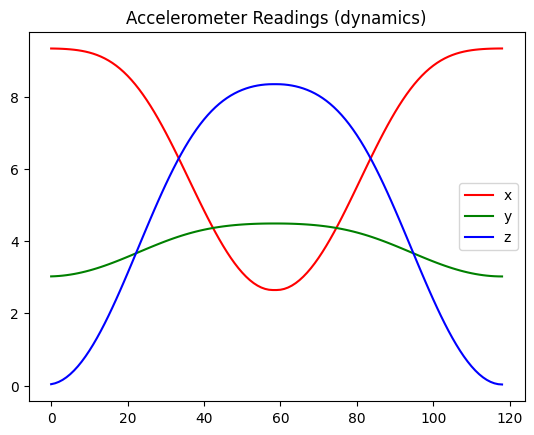

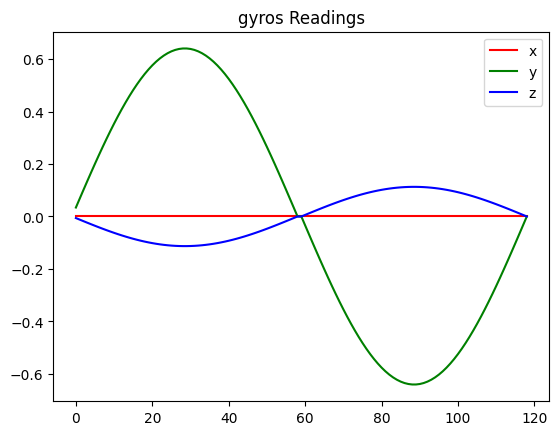

In [11]:
# world_acc_hand = np.array(world_acc_hand)
# world_acc_root = np.array(world_acc_root)

# # Plot shoulder IMU Accelerometer readings
# plt.plot(world_acc_hand[:,0], 'r', label = "x")
# plt.plot(world_acc_hand[:,1], 'g', label = "y")
# plt.plot(world_acc_hand[:,2], 'b', label = "z")
# plt.legend()
# plt.title("Elbow linear acceleration")
# plt.show()

# # Plot shoulder IMU Accelerometer readings
# plt.plot(world_acc_root[:,0], 'r', label = "x")
# plt.plot(world_acc_root[:,1], 'g', label = "y")
# plt.plot(world_acc_root[:,2], 'b', label = "z")
# plt.legend()
# plt.title("Pelvis linear acceleration")
# plt.show()

# Plot shoulder IMU Accelerometer readings
plt.plot(accels[:,0], 'r', label = "x")
plt.plot(accels[:,1], 'g', label = "y")
plt.plot(accels[:,2], 'b', label = "z")
plt.legend()
plt.title("Accelerometer Readings (dynamics)")
plt.show()
# Plot shoulder IMU Accelerometer readings
plt.plot(gyros[:,0], 'r', label = "x")
plt.plot(gyros[:,1], 'g', label = "y")
plt.plot(gyros[:,2], 'b', label = "z")
plt.legend()
plt.title("gyros Readings")
plt.show()

In [ ]:
import cvxpy as cp

def estimate_position_from_IMUs_qp(s,acc_target=None, gyro_target=None, max_iterations=100, precision=0.001, dt=1/60):
    
    # Variable declaration
    dq = cp.Variable((49,))
    delta_a =  cp.Variable((9,))
    delta_w =  cp.Variable((9,))
    
    # Acc
    if acc_target is not None:
        a = cp.Parameter((9,))
        aT = cp.Parameter((9,)) 
        Ja = cp.Parameter((9,49))
    
    # Gyro
    if gyro_target is not None:
        w = cp.Parameter((9,))
        wT = cp.Parameter((9,)) 
        Jw = cp.Parameter((9,49))
    
    # Position
    q = cp.Parameter((49,))
    q_l = cp.Parameter((49,))
    q_u = cp.Parameter((49,))
    dq_l = cp.Parameter((49,))
    dq_u = cp.Parameter((49,))
    
    # Problem building
    constraints = []
    if acc_target is not None:
        constraints += [a + Ja@dq + delta_a == aT]
    
    if gyro_target is not None:
        constraints += [w + 1*Jw@dq + delta_w == wT]
    
    dq_cumulative = np.zeros(q.shape)
    constraints += [dq <= q_u - q]
    constraints += [dq >= q_l - q]
    # constraints += [dq_cumulative + dq >= dq_l, dq_cumulative + dq <= dq_u]  # velocity
    constraints += [dq >= dq_l, dq <= dq_u]  # velocity limit
                         
    lambda_reg  = 10
    weight_acc  = 1 if acc_target is not None else 0.0
    weight_gyro = .01 if gyro_target is not None else 0.0
    to_minimize = (
        lambda_reg * cp.sum_squares(dq) +
        weight_acc * cp.sum_squares(delta_a) +
        weight_gyro * cp.sum_squares(delta_w)
    )
    
    obj = cp.Minimize(to_minimize)
    prob = cp.Problem(obj, constraints)
    
    q_l.value = np.clip(s.q_l,-1000,1000)
    q_u.value = np.clip(s.q_u,-1000,1000)
    dq_l.value = dt*s.qdot_l
    dq_u.value = dt*s.qdot_u

    i=0
    while i < max_iterations:
        i+=1
        # Parameters initialization
        q.value = s._nimble.getPositions()
        
        if acc_target is not None:
            aT.value = acc_target
            a.value = s._nimble.getAccelerometerReadings(s.IMUs)
            Ja.value = s._nimble.getAccelerometerReadingsJacobianWrt(accs=s.IMUs, wrt=nimble.neural.WRT_POSITION)
        
        # print("Raw aT (target):", aT.value[0:3], "Model accel (Nimble):", a.value[0:3])
        
        if gyro_target is not None:
            wT.value = gyro_target
            w.value = s._nimble.getGyroReadings(s.IMUs)
            print("Gyro error:", np.linalg.norm(w.value - wT.value), w.value[0:3],gyro_target[0:3])
            Jw.value = s._nimble.getGyroReadingsJacobianWrt( gyros=s.IMUs, wrt=nimble.neural.WRT_POSITION)

        prob.solve(solver=cp.OSQP, warm_start=True)
        dq_cumulative += np.array(dq.value)
        
        s._nimble.setPositions(q.value + dq.value)
        # s._nimble.setVelocities(dq_cumulative / dt)
        
        if np.linalg.norm(dq.value.flatten()) < precision:
            break
    print("--- problem value:", prob.value)

In [ ]:
# Move the skeleton
s.reset()
s12.load_from_numpy(target[0,:].reshape(-1,3), s.kps)
s.load_from_BODY12(s12)
s.exact_scale(to_scale=False)
s._nimble.setGravity(np.array([0.0, 0.0, -9.81]))

# Initial pose
# q = s._nimble.getPositions()
# q[32] = np.radians(-80)
# q[34] = np.radians(10)
# q[33] = np.radians(0)

s._nimble.setPositions(positions[0,:])
s._nimble.setVelocities(velocities[0,:])
s._nimble.setAccelerations(accelerations[0,:])

# s._nimble.computeForwardDynamics()


gui.nativeAPI().renderSkeleton(s._nimble)
[plot_imu(sensor, axis_length=0.05, imu_key='imu'+str(j)) for j, sensor in enumerate(sensors)]

# Initialize storage
qs_imu = [positions[0,:],]
r_elbow_3dpos_imu = [s._nimble.getJointWorldPositions([s.joints[6]])]

# Variables to compute velocity and acceleration
prev_q = q.copy()
prev_qdot = np.zeros_like(prev_q)
dt = 1 / 60.0  # 60 FPS assumed

for i in range(1, accels.shape[0]):
    # Estimate pose using current IMU data
    estimate_position_from_IMUs_qp(s, acc_target=accels[i], gyro_target=gyros[i])
    q = s._nimble.getPositions().copy()
    qdots = (q - qs_imu[-1])/dt
    s._nimble.setVelocities(qdots)
    
    
    # Store and update
    qs_imu.append(q.copy())
    r_elbow_3dpos_imu.append(s._nimble.getJointWorldPositions([s.joints[6]]))
    gui.nativeAPI().renderSkeleton(s._nimble)
    [plot_imu(sensor, axis_length=0.05, imu_key='imu'+str(j)) for j, sensor in enumerate(sensors)]
    gui.nativeAPI().createSphere(key='elbow_gt', radii=np.array([0.01,0.01,0.01]),pos=r_elbow_3dpos[i],color=np.array([255,255,0,1]))

    prev_q = q.copy()
    time.sleep(0.01)

qs_imu = np.array(qs_imu)

Gyro error: 0.06914804685750059 [0. 0. 0.] [ 0.          0.06809753 -0.01200743]
Gyro error: 0.06914804685750059 [0. 0. 0.] [ 0.          0.06809753 -0.01200743]
--- problem value: 0.00024197413512419986
Gyro error: 0.10262922251097656 [-0.05924398  0.18356286 -0.03632255] [ 0.          0.10190494 -0.01796859]
Gyro error: 0.10262902688822656 [-0.0592503   0.183601   -0.03613034] [ 0.          0.10190494 -0.01796859]
--- problem value: 0.000532380769108336
Gyro error: 0.12290924404746129 [-0.0744614   0.23128164 -0.04315301] [ 0.          0.13542349 -0.02387882]
Gyro error: 0.12291874881467234 [-0.07448292  0.23134544 -0.04280996] [ 0.          0.13542349 -0.02387882]
--- problem value: 0.0007668863741059593
Gyro error: 0.18867202409701408 [-0.10367377  0.32267284 -0.06277582] [ 0.          0.16855817 -0.02972135]
Gyro error: 0.18868297889731916 [-0.10371064  0.32279151 -0.0621635 ] [ 0.          0.16855817 -0.02972135]
Gyro error: 0.1886848648644497 [-0.10371674  0.32280939 -0.06206982

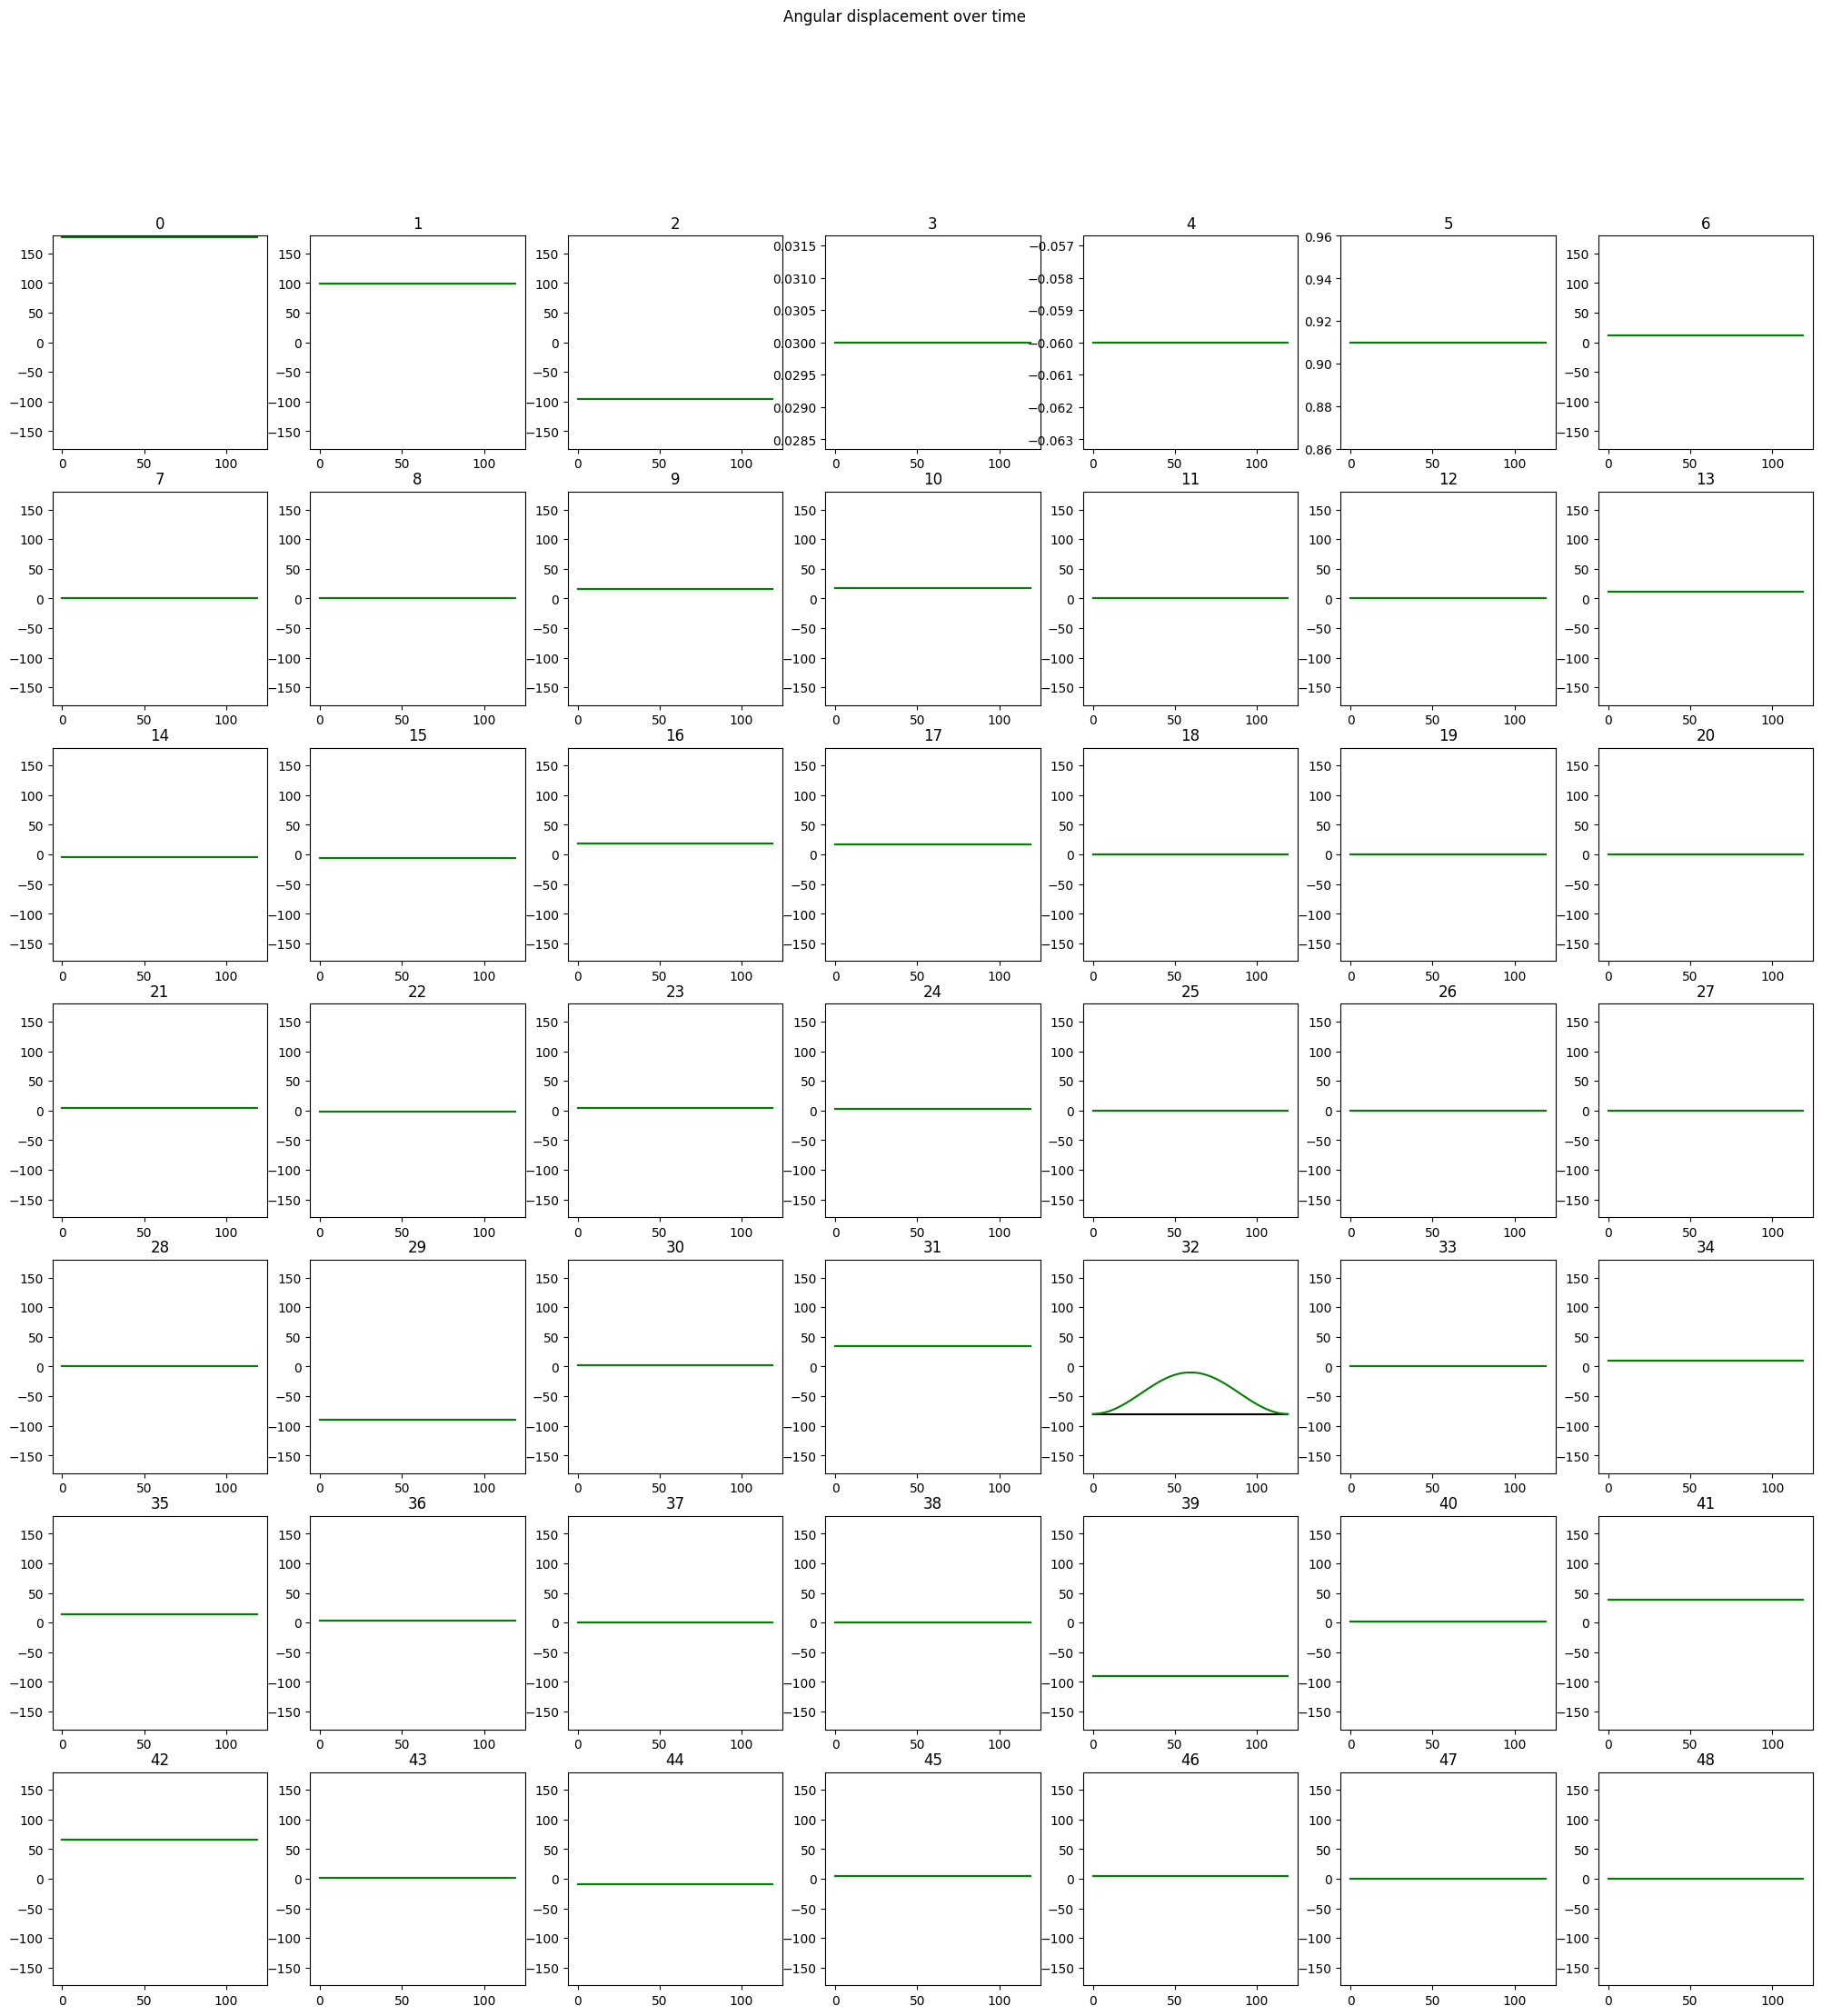

127.0.0.1 - - [24/Jul/2025 15:33:53] code 404, message File not found
127.0.0.1 - - [24/Jul/2025 15:33:53] "GET /v1/health HTTP/1.1" 404 -


In [16]:
fig, axs = plt.subplots(7, 7,figsize=(25, 25))
fig.suptitle('Angular displacement over time')
for i in range(0,7):
    for j in range(0,7):
        dof = i*7 + j
        if dof not in [3,4,5]:
            axs[i, j].set_ylim([-180, 180])
            axs[i, j].plot(np.round(np.degrees(qs_imu[:,dof]),2),'k')
            axs[i, j].plot(np.round(np.degrees(positions[:,dof]),2),'g')
            axs[i, j].set_title(str(dof))
        else:
            axs[i, j].plot(np.round(qs_imu[:,dof],2),'k')
            axs[i, j].plot(np.round(positions[:,dof],2),'g')
            axs[i, j].set_title(str(dof))
        


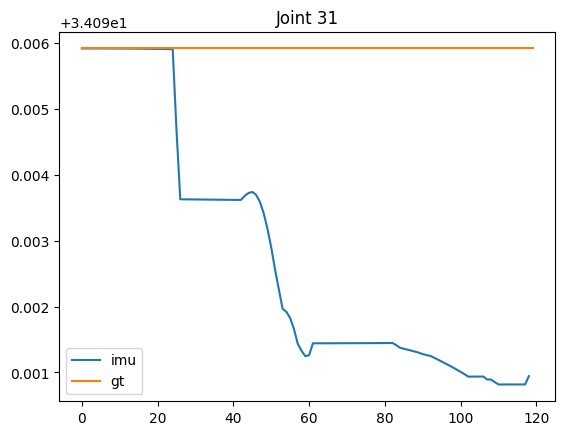

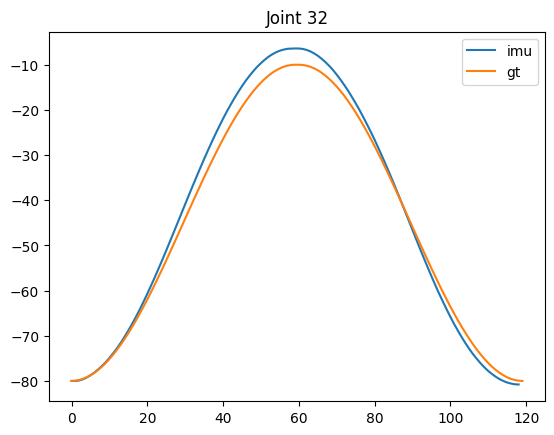

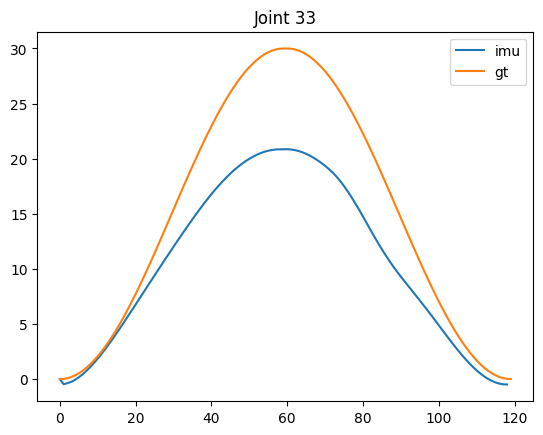

127.0.0.1 - - [24/Jul/2025 11:27:31] code 404, message File not found
127.0.0.1 - - [24/Jul/2025 11:27:31] "GET /v1/health HTTP/1.1" 404 -
127.0.0.1 - - [24/Jul/2025 11:28:01] code 404, message File not found
127.0.0.1 - - [24/Jul/2025 11:28:01] "GET /v1/health HTTP/1.1" 404 -
127.0.0.1 - - [24/Jul/2025 11:28:31] code 404, message File not found
127.0.0.1 - - [24/Jul/2025 11:28:31] "GET /v1/health HTTP/1.1" 404 -
127.0.0.1 - - [24/Jul/2025 11:29:01] code 404, message File not found
127.0.0.1 - - [24/Jul/2025 11:29:01] "GET /v1/health HTTP/1.1" 404 -
127.0.0.1 - - [24/Jul/2025 11:29:31] code 404, message File not found
127.0.0.1 - - [24/Jul/2025 11:29:31] "GET /v1/health HTTP/1.1" 404 -
127.0.0.1 - - [24/Jul/2025 11:30:01] code 404, message File not found
127.0.0.1 - - [24/Jul/2025 11:30:01] "GET /v1/health HTTP/1.1" 404 -


In [42]:
# Elbow MAE
# mae = np.mean(np.abs(np.array(r_elbow_3dpos)-np.array(r_elbow_3dpos_imu)), axis=1)
# plt.plot(mae)
# plt.title("MAE Elbow: "+str(np.round(np.mean(mae),2))+" m")
# plt.show()

# Plot shoulder joint position

plt.plot(np.degrees(qs_imu[:,32]), label = "imu")
plt.plot(np.degrees(positions[:,32]), label = "gt")
plt.title("Joint 32")
plt.legend()
plt.show()


### Other tests

In [ ]:
# Move the body model using accelerometers only and compare it against gt
kps = list(markers_dict.keys())

# Place virtual IMUs on the shoulders and thorax
s_gt = DynamicSkeleton(config='BODY15_constrained_3D.xml',osim_file='/home/emartini/COMETH/COMETH/bsm_upper.osim')
s_gt.hip_correction = False
s_gt.reset()
from typing import List, Tuple

# Add IMU to gt as well
right_shoulder: nimble.dynamics.BodyNode = s_gt._nimble.getBodyNode("humerus_r")
translation: np.ndarray = np.array([0.0, 0.0, 0.04])
# z is pointing up, x lateral and y frontal
rotation: np.ndarray = np.array([[1,0,0],[0,0,1],[0,-1,0]]) @ np.array([[0,1,0],[-1,0,0],[0,0,1]])
watch_offset: nimble.math.Isometry3 = nimble.math.Isometry3(rotation, translation)

left_shoulder: nimble.dynamics.BodyNode = s_gt._nimble.getBodyNode("humerus_l")
translation: np.ndarray = np.array([0.0, 0.0, -0.04])
rotation: np.ndarray = np.array([[1,0,0],[0,0,1],[0,-1,0]]) @ np.array([[0,1,0],[-1,0,0],[0,0,1]])
watch_offset2: nimble.math.Isometry3 = nimble.math.Isometry3(rotation, translation)

thorax: nimble.dynamics.BodyNode = s_gt._nimble.getBodyNode("thorax")
translation: np.ndarray = np.array([0.1, -0.1, 0])
rotation: np.ndarray = np.array([[1,0,0],[0,0,1],[0,-1,0]]) @ np.array([[0,1,0],[-1,0,0],[0,0,1]])
watch_offset3: nimble.math.Isometry3 = nimble.math.Isometry3(rotation, translation)

sensors: List[Tuple[nimble.dynamics.BodyNode, nimble.math.Isometry3]] = \
    [(right_shoulder, watch_offset),
     (left_shoulder, watch_offset2),
     (thorax, watch_offset3),
     ]
s_gt.IMUs = sensors


# Skeleton moved by GT
s_gt.reset()
s12.load_from_numpy(target[0,:].reshape(-1,3)+[1,0,0],s.kps)
s_gt.load_from_BODY12(s12)
s_gt.exact_scale()

# Skeleton moved by IMUs
s.reset()
s12.load_from_numpy(target[0,:].reshape(-1,3),s.kps)
s.load_from_BODY12(s12)
s.exact_scale()
s._nimble.setGravity(np.array([0.0, 0.0, -9.81]))

gui.nativeAPI().renderSkeleton(s._nimble)
gui.nativeAPI().renderSkeleton(s_gt._nimble,prefix='gt',overrideColor=np.array([0,255,0,0.8]))

q0 = s_gt._nimble.getPositions()

qs_imu = []
qs = []

for i in range(1,round(target.shape[0]/4)):
    s12.load_from_numpy(target[i,:].reshape(-1,3)+[1,0,0],s.kps)
    s_gt.load_from_BODY12(s12)

    # Move with IK
    s_gt.exact_scale(max_iterations=100,to_scale=False)
    qs.append(s_gt._nimble.getPositions().copy())

    # Move with accel
    acc_readings = s_gt._nimble.getAccelerometerReadings(s_gt.IMUs)
    estimate_position_from_IMUs(s,acc_target=acc_readings)
    qs_imu.append(s._nimble.getPositions().copy())

    [plot_imu(sensor,axis_length=0.05,imu_key='imu'+str(j)) for j,sensor in enumerate(s.IMUs)]
    gui.nativeAPI().renderSkeleton(s._nimble)

    q_gt = s_gt._nimble.getPositions()
    q_gt[0:6] = q0[0:6] # Do not update the pelvis position in the worlds
    q_gt = s_gt._nimble.setPositions(q_gt)
    gui.nativeAPI().renderSkeleton(s_gt._nimble,prefix='gt',overrideColor=np.array([0,255,0,0.8]))

    s.reset_history()
    s_gt.reset_history()
    # time.sleep(0.01)
qs_imu = np.array(qs_imu)
qs = np.array(qs)

In [ ]:
import matplotlib.pyplot as plt
# print(qs_imu[32])
# print(qs[32])
plt.plot(np.degrees(qs_imu[:,32]), label = "imu")
plt.plot(np.degrees(qs[:,32]), label = "gt")
plt.show()